# Network Analysis for Strategic Development of a young University
In this work we will explore the possibilities for a young university to strategically target other institutions with which to partner.
Partnering with installed institutions might for example take the form of collaborating on research and in writing academic papers, launching new joint programs.


In [1]:
## Packages needed for the project
# Network Analysis
import networkx as nx
import community as community_louvain
# Data Visualisation
from nxviz import CircosPlot
import matplotlib.pyplot as plt
# Numerical Processing
import numpy as np
# Managing Data Structures
import pandas as pd
from collections import Counter

np.random.seed(777)
# %matplotlib inline

### Importing the data and Creating the network

In [2]:
universities = pd.read_csv('./datasets/HW_2-dataset_university.csv')
specialties = pd.read_csv('./datasets/HW_2-dataset_specialty.csv')

In [3]:
def generate_edges(nb_nodes):
    '''
    Generates a list of random edges with random weight in [0, 9[
    Create around 3 times as much edges as the total number of nodes
    :param nb_nodes: number of nodes in the graph_stats
    :return: a tuple of (node_1, node_2, weight of the edge)
    '''
    edges = []
    for i in range(3 * nb_nodes):
        random_edge = (np.random.randint(0, nb_nodes), np.random.randint(0, nb_nodes), np.random.randint(0, 9))
        if random_edge not in edges:
            edges.append(random_edge)
    return edges

In [4]:
def create_graphs(nodes, viewpoints):
    """
    Create a different graph_stats for each field of specialization.
    By doing this, the analysts can see more clearly who are the main academic actors in the given field
        nodes (pandas DataFrame): Dataframe containing the nodes to be created
        viewpoints (pandas Dataframe): Dataframe containing the different lenses through which
                                        to represent the nodes
    """
    graphs = []
    for index, field in viewpoints.iterrows():
        specialty = field[0]
        #create the graph_stats
        graph = nx.Graph(specialty=specialty)
        graph.add_nodes_from(nodes['university'])
        for node, i in zip(graph.nodes(), range(len(graph.nodes()))):
        # We add the 'country' attribute to each node
            # to distinguish nodes from the same country in the network
            graph.nodes[node]['country'] = nodes['country'][i]

        # For now we generate a random weighted list of edges
        # due to lack of time to gather a sufficient number of papers to represent the edges of our network
        edges = generate_edges(nodes.shape[0])
        list_nodes = list(graph.nodes())
        for edge in edges:
            graph.add_edge(list_nodes[edge[0]], list_nodes[edge[1]], weight=edge[2])

        graphs.append(graph)
    return graphs

In [5]:
graphs = create_graphs(universities, specialties)
graph_interest = graphs[0]

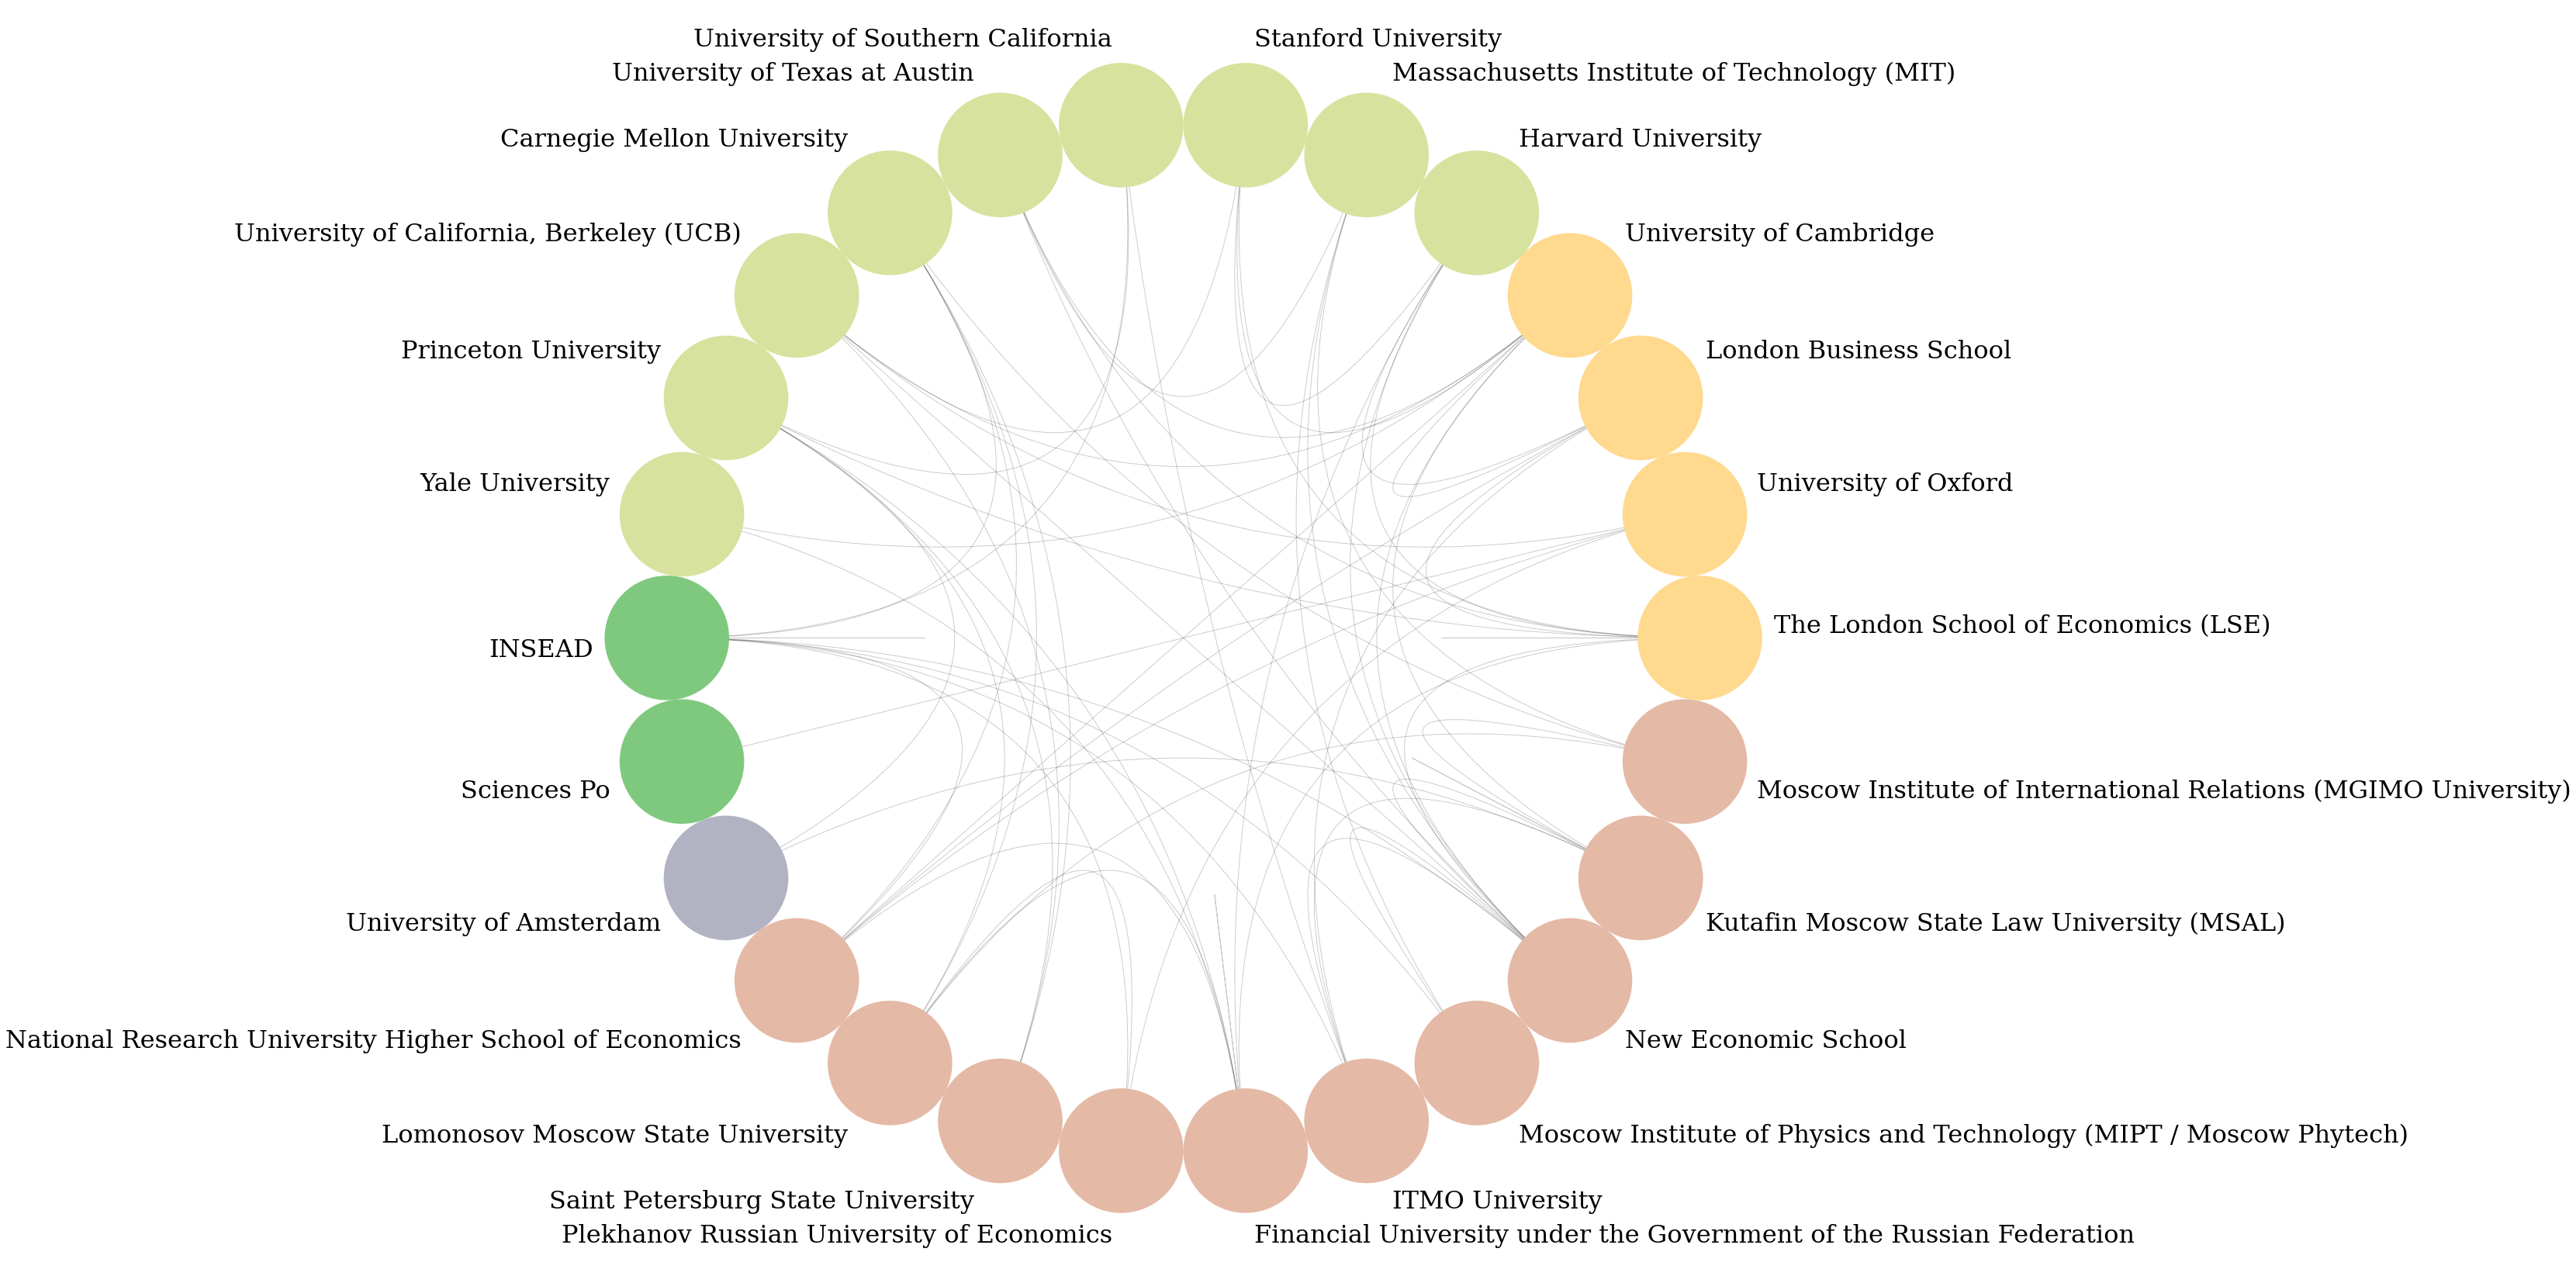

In [6]:
plot = CircosPlot(graph_interest,
                  node_color='country',
                  node_grouping='country',
                  node_labels=True,
                  fontsize=32,
                  figsize=(30, 30))
plot.draw()

In [ ]:
plt.savefig('./images/{}'.format(graph_interest.graph['specialty']), dpi=300)

### Summary & Statistics of the network

In [17]:
def print_general_statistics(graph_stats):
    '''
    Prints summary statistics about the given graph of interest
    :param graph_stats: dictionnary of attributes of the graph of interest
    :return: None
    '''
    print('Name of the graph: {}'.format(graph_stats['name']))
    print('The graph has {} nodes and {} edges'.format(graph_stats['nb_nodes'], graph_stats['nb_edges']))
    print('\n{} countries are represented in the graph:'.format(len(graph_stats['dict_by_country'].keys())))
    for country in graph_stats['dict_by_country'].keys():
        print(country)
    print('-------------')
    print('Centralities of the nodes ordered by importance:')
    print('---')
    print('Degree centrality:\n')
    for university in graph_stats['degree_centrality']:
        print(university[0], round(university[1], 3))
    print('---')
    print('Betweenness centrality:\n')
    for university in graph_stats['betweenness_centrality']:
        print(university[0], round(university[1], 3))
    print('---')
    print('Eigenvector centrality:\n')
    for university in graph_stats['eigenvector_centrality']:
        print(university[0], round(university[1], 3))

    if 'components' in graph_stats:
        pass
    else:
        print('\nThe graph is fully connected\n')

    if 'communities' in graph_stats:
        print('The graph has {} communities:'.format(len(graph_stats['communities'])))
        for community in graph_stats['communities']:
            print('----')
            print('Community {}\n'.format(community[0]))
            for university in community[1]:
                print(university)
    else:
        print('The graph_stats has no communities')

In [19]:
def print_node_statistics(node_stats):
    '''
    Prints summary statistics about the node of interest
    :param node: node of interest
    :return: None
    '''
    print('Node of interest: {}'.format(node_stats['name']))
    print('Degree centrality: {}'.format(node_stats['degree']))
    print('The node is part of {} cliques'.format(node_stats['triangles']))

    print('----')
    print('Node\'s neighborhood:\n')
    for neighbor in node_stats['neighbors']:
        print(neighbor)

    if node_stats['name'] not in node_stats['neighbors']:
        node_stats['neighbors'].insert(0, node_stats['name'])
    subnetwork_node = graph_interest.subgraph(node_stats['neighbors'])
    nx.draw(subnetwork_node, with_labels=True)

In [9]:
def general_statistics(graph):
    '''
    Computes summary statistics for a given graph_stats
    :param graph: the graph_stats from which we want statistics
    :return: dictionary of statistics
    '''
    statistics = {}
    statistics['name'] = graph.graph['specialty']
    nb_nodes = len(graph.nodes())
    statistics['nb_nodes'] = nb_nodes
    nb_edges = len(graph.edges())
    statistics['nb_edges'] = nb_edges

    ## Centralities
    # list of the number of universities from each country represented
    dict_by_countries = Counter([attributes['country'] for id, attributes in graph.nodes(data=True)])
    statistics['dict_by_country'] = dict_by_countries
    # sorted list of most important nodes in network
    # sorted_degree = sorted([(id, len(list(graph_stats.neighbors(id)))) for id in graph_stats.nodes()], key=lambda node: node[1], reverse=True)

    # sorted relative degree centrality
    degree_centralities = sorted(nx.degree_centrality(graph).items(), key=lambda node: node[1], reverse=True)
    statistics['degree_centrality'] = degree_centralities
    # sorted betweenness centrality
    betweenness_centralities = sorted(nx.betweenness_centrality(graph, normalized=True).items(), key=lambda node: node[1], reverse=True)
    statistics['betweenness_centrality'] = betweenness_centralities
    # eigenvector centrality
    eigenvetor_centrality = sorted(nx.eigenvector_centrality(graph).items(), key=lambda node: node[1], reverse=True)
    statistics['eigenvector_centrality'] = eigenvetor_centrality

    # are there components inside the networks ?
    components = list(nx.connected_components(graph))
    if len(components) > 1:
        statistics['components'] = components
    # Are there communities ?
    partitions  = community_louvain.best_partition(graph)
    if len(partitions) > 1:
        communities = []
        for community in set(partitions.values()):
            list_nodes = [node for node in partitions.keys() if partitions[node] == community]
            communities.append((community, list_nodes))
        statistics['communities'] = communities

    return statistics

In [10]:
def node_statistics(node):
    '''
    Computes summary statistics for a node of interest
    :param node: a string representing the name of the node from which we want statistics
    :return: dictionary of statistics
    '''
    statistics = {}
    statistics['name'] = node
    degree_node = graph_interest.degree()[node]
    statistics['degree'] = degree_node
    neighbors_node = list(graph_interest.neighbors(node))
    statistics['neighbors'] = neighbors_node

    # cliques
    triangles = nx.triangles(graph_interest, node)
    if triangles > 1:
        statistics['triangles'] = triangles

    return statistics

In [11]:
def relation_statistics(node_source, node_target):
    '''
    Computes statistics about the relationship between the node_source and node_target
    :param node_source: node source
    :param node_target: node target
    :return: dictionary of statistics
    '''
    if nx.has_path(graph_interest, node_source, node_target):
        shortest_path = nx.shortest_path(graph_interest, node_source, node_target)
    return shortest_path

In [12]:
graph_statistics = general_statistics(graph_interest)

In [13]:
node_interest = node_statistics('National Research University Higher School of Economics')

In [18]:
print_general_statistics(graph_statistics)

Name of the graph: Accounting and Finance
The graph has 26 nodes and 65 edges

5 countries are represented in the graph:
United States
United Kingdom
Russia
France
Netherlands
-------------
Centralities of the nodes ordered by importance:
---
Degree centrality:

New Economic School 0.4
The London School of Economics (LSE) 0.36
INSEAD 0.36
Financial University under the Government of the Russian Federation 0.32
University of Cambridge 0.32
Kutafin Moscow State Law University (MSAL) 0.28
National Research University Higher School of Economics 0.24
Princeton University 0.24
Harvard University 0.2
Lomonosov Moscow State University 0.2
London Business School 0.2
Carnegie Mellon University 0.2
University of California, Berkeley (UCB) 0.2
ITMO University 0.2
Massachusetts Institute of Technology (MIT) 0.16
Stanford University 0.16
University of Oxford 0.16
University of Texas at Austin 0.16
Moscow Institute of International Relations (MGIMO University) 0.16
Saint Petersburg State University 0

Node of interest: National Research University Higher School of Economics
Degree centrality: 6
The node is part of 2 cliques
----
Node's neighborhood:

National Research University Higher School of Economics
INSEAD
University of Cambridge
University of Oxford
London Business School
Carnegie Mellon University
Financial University under the Government of the Russian Federation


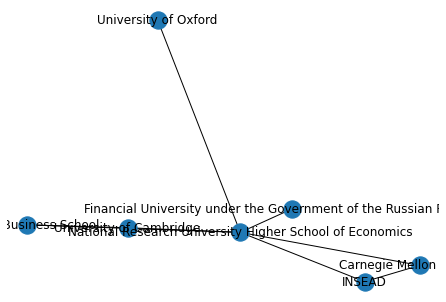

In [20]:
print_node_statistics(node_interest)